In [30]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt, random

import numpy as np

sin = np.sin
cos = np.cos
pi = np.pi
arctan = np.arctan
sqrt = np.sqrt
exp = np.exp
from scipy.integrate import solve_ivp
def hide_code_in_slideshow():   
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

# <center>Численное моделирование ядра в самосогласованном среднем поле.
</center>

>Вещество есть на деле огромная концентрация энергии в сравнительно малом пространстве.
>
>А.Эйнштейн

                                                                                                Шишкин Максим
                                                                                                2020

## Nuclear Shell Model
Магические ядра
$$
\hat{H}\Psi = E\Psi, \; \hat{H} = \hat{T_i} + \hat{U_i} + \frac{1}{2}\hat{V}_{i,j}\implies \hat{V}_{eff}(r_i)
$$
Спин-орбита


Частица в кусочно квадратичной потенциальной яме после разделения переменных на угловую и радиальную составляющую и классического анзаца $\chi = r R$ и обезразмеренниваний сводится к уравнению
$$\label{task}
[\partial^2_u -(V(u)-\lambda)]\chi=0,\; V(u) = \frac{l(l+1)}{u^2} - \left(1-\frac{a^2}{R^2}\,u^2\right) \cdot \mathcal{I}_{u<R/a},
$$
$$
a^2 =\frac{\hbar^2}{2m U_0}
$$


In [19]:
%matplotlib inline

hbar = 1.054571817*1e-34 #Си
m = 1.67262192369*1e-27 # кг
c = 3*1e8 # си
U_0 = 60 # Mev
U_0 *= 1.6021766e-13 # дж
R_0  = 1.3*40**(1/3)*1e-15 # м

a = sqrt(hbar**2/2/m/U_0)

def up(x, aa=a, Rr = R_0):
    return (-1)*(x < Rr/aa)*(1-aa**2/Rr**2 * x**2)

@interact_manual(l=(0, 4, 1))
def cons(l):
    
    x = np.linspace(0.01, R_0/a*1.2 , 1000)
    u = up(x)
    v = l*(l+1) / x**2
    plt.figure(figsize=(7,7))
    plt.plot(x, v+u)
    plt.grid()
    plt.ylim(-1, 3)
    plt.title(f'l={l}')

interactive(children=(IntSlider(value=2, description='l', max=4), Button(description='Run Interact', style=But…

У уравнения \ref{task} для любого значения $\lambda$ существует решение, а условием связанности является затухание на бесконечности, однако как легко видеть на больших $r$ $\chi\sim \exp(\pm \sqrt{-\lambda})$, так же легко видеть что затухающее решение не устойчиво -даже малый коэффициент перед растущей экспонентой приведет к взрыву решения.

Радиальная часть вф связанного состоянияния выглядят примерно следуюзим образом, где количество узлов ВФ в соответсвии с осциляторной теоремой говорит о порядковом номере уровня энергии.
![](https://github.com/maxkway/testuou/blob/master/diagram-20200605.png?raw=true)


Решение - следить за углом:
$$\label{anzac}
\chi \sin\varphi - \chi'\cos\varphi=0
$$
Наглядный смысл :
![](https://github.com/maxkway/testuou/blob/master/diagram-20200605%20(1).png?raw=true)

Граничное условие имеет вид:
$$
    \varphi(0) = \frac{\pi}{2} 
$$
А краевое на спекральную задачу:
$$
\varphi(\infty) = \frac{\pi}{2} - \pi k
$$
Где под $k$ указан номер искомого связанного сотояния.

Дифферинцируя анзац \eqref{anzac} и подставляя $\chi''$ из исходного \eqref{task} получаем совместно с анзацем однородную систему для $\chi, \chi'$ ; приравнивая нулю детерминант получаем уравнение на $\varphi$:
$$\boxed{\cases{
\varphi' + \sin^2\varphi + (\lambda - V(r))\cos^2 \varphi=0, \\
\varphi(r\rightarrow 0) = \tan^-\left(\frac{l+1}{r}\right) = \frac{\pi}{2}-\tan^-\left(\frac{r}{l+1}\right)}}
$$
P.s. Если нас заинтересует сама волновая функция, то необходимо просто проинтегрировать следующее выражение для амплитуды:
$$
\frac{A'}{A} = \cos\varphi\sin\varphi(1+V(r)-\lambda)
$$

In [20]:
#%matplotlib notebook
def derivate(r, phi, energy, l):
    v = up(r) + l*(l+1) / r**2
    return -((sin(phi))**2 + (energy - v) * (cos(phi))**2)

@interact_manual(energy=(-1, 0, 0.01), l=(0, 5, 1))
def draw_phi(energy, l):
    
    r_star = 200
    r_min = 1e-6
    r = (r_min, r_star)
    init = pi/2 - arctan(r_min/(l+1)) # from zero asimptotic
    
    soll =solve_ivp(derivate, r, [init], args=(energy, l), atol=1e-10, rtol=1e-6, method="DOP853")
    r = soll.t
    phi = soll.y[0]
    
    plt.figure()
    plt.plot(r, phi,'r.--')
    plt.hlines(pi/2 - 2*pi, 0, 40)
    plt.hlines(pi/2, 0, 40)    
    plt.grid()
    plt.yticks([pi/2, -pi/2, -3*pi/2, -5*pi/2], labels=[r'$\pi/2$', r'$-\pi/2$', r'$-3\pi/2$', r'$-5\pi/2$'])
    plt.xlim(0, 15)
    plt.ylim(-8, 2)
    plt.xlabel('r')
    plt.title('Зависимость угла от радиуса')
    plt.ylabel(r'$\varphi$')

interactive(children=(FloatSlider(value=-1.0, description='energy', max=0.0, min=-1.0, step=0.01), IntSlider(v…

Теперь остаётся подобрать $\lambda$ чтобы посадить на "нужную"" асимптотику.
Для этого зафиксируем далёкую точку $r_{\star}$, в которую будем вычислять $\varphi$.

Остаётся найти корень уравнения 
$\boxed{\varphi(r_{\star}) = \pi/2 - \pi k}$

In [31]:
def get_val_r_star(energy, l, method="DOP853", r=(1e-7,200)):
    init = pi/2 - arctan(r[0]/(l+1)) # from zero asimptotic
    soll = solve_ivp(derivate, r, [init], args=(energy, l), atol=1e-10, rtol=1e-6, method=method)
    return soll.y[0, -1]

In [32]:
from scipy.optimize import brentq
def get_energies(l, en_tol=1e-4):
    energies=[]
    for i in range(20):
        
        phi_end = pi/2 - pi*(i+1)
        target_fun = lambda phi: phi - phi_end
        
        phi_zero_en = get_val_r_star(0, l)
        
        xi = (l*(l+1)*(R_0/a)**2)**0.25
        e_min = (xi < R_0/a)*(-1+a**2/R_0**2 * xi**2) + l*(l+1) / xi**2 if l>0 else -1
        
        phi_bot_en = get_val_r_star(e_min, l)
        
        if target_fun(phi_zero_en) * target_fun(phi_bot_en) < 0 and e_min<0:
            en = brentq(lambda en: target_fun(get_val_r_star(en, l)), e_min , 0, xtol=en_tol)
            energies.append(en)
        else:
            break
    return np.array(energies)

In [6]:
@interact_manual(l=(0, 3, 1))
def cons(l):
    x = np.linspace(0.01, 15 , 1000)
    u = (x < R_0/a)*(1-a**2/R_0**2 * x**2)
    v = l*(l+1) / x**2
    
    energies = get_energies(l)
    plt.figure(figsize=(6,6))
    plt.title(f'l={l}')
    plt.plot(x, v-u)
    for energy in energies:
        left_x = 0.1 #sqrt(l*(l+1) / (energy+f))
        plt.hlines(energy, left_x, 15,'r')
        print(energy*60)
    plt.grid()
    plt.ylim(-1, 1)
    plt.hlines(0, 0, 15, alpha=0.6, color='black')

interactive(children=(IntSlider(value=1, description='l', max=3), Button(description='Run Interact', style=But…

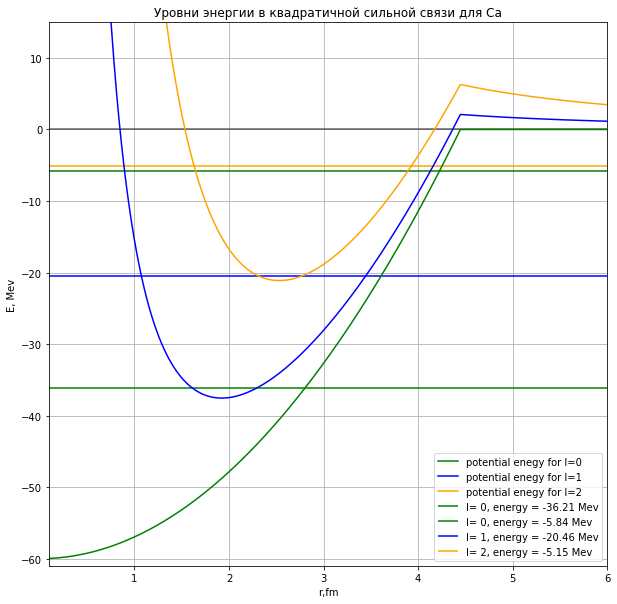

In [24]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.title(f'Уровни энергии в квадратичной сильной связи для Ca')
l=0
x = np.linspace(0.01, 15 , 1000)
u = (x < R_0/a)*(1-a**2/R_0**2 * x**2)
v = l*(l+1) / x**2

energies = get_energies(l)

plt.plot(x*a*1e15, (v-u)*60, label = f'potential enegy for l={l}',color='green')
for energy in energies:
    left_x = 0.1 #sqrt(l*(l+1) / (energy+f))
    plt.hlines(energy*60, left_x*a*1e15, 15*a*1e15, label = 'l= %.1i, energy = %.2f Mev' % (l,energy*60), color='green')
l=1
x = np.linspace(0.01, 15 , 1000)
u = (x < R_0/a)*(1-a**2/R_0**2 * x**2)
v = l*(l+1) / x**2

energies = get_energies(l)

plt.plot(x*a*1e15, (v-u)*60, label = f'potential enegy for l={l}',color='blue')
for energy in energies:
    left_x = 0.1 #sqrt(l*(l+1) / (energy+f))
    plt.hlines(energy*60, left_x*a*1e15, 15*a*1e15, label = 'l= %.1i, energy = %.2f Mev' % (l,energy*60), color='blue')
l=2
x = np.linspace(0.01, 15 , 1000)
u = (x < R_0/a)*(1-a**2/R_0**2 * x**2)
v = l*(l+1) / x**2

energies = get_energies(l)

plt.plot(x*a*1e15, 60*(v-u), label = f'potential enegy for l={l}',color='orange')
for energy in energies:
    left_x = 0.1 #sqrt(l*(l+1) / (energy+f))
    plt.hlines(energy*60, left_x*a*1e15, 15*a*1e15, label = 'l= %.1i, energy = %.2f Mev' % (l,energy*60),color='orange' )

plt.grid()
plt.ylim(-61, 15)
plt.xlim(0.1, 6)
plt.legend()
plt.xlabel('r,fm')
plt.ylabel('E, Mev')
plt.hlines(0, 0, 15, alpha=0.6, color='black')
plt.savefig('Levels_in_Ca.pdf')

In [25]:
import bokeh.plotting as bplt
bplt.output_notebook()


color = {1:'red', 0:'purple', 2:'blue', 3:'orange', 4:'green', 5:'pink', 6:'steelblue'}
moment = {0:'s', 1:'p', 2:'d', 3:'f', 4:'e', 5:'g'}
@interact_manual(u=(0, 300, 5))
def plot_levels(u):
    u_j =u* 1.6021766e-13 # дж
    R_0  = 1.3*40**(1/3)*1e-15 # м
    a = sqrt(hbar**2/2/m/u_j)
    def up(x):
        return (-1)*(x < R_0/a)*(1-a**2/R_0**2 * x**2)
    def derivate(r, phi, energy, l):
        v = up(r) + l*(l+1) / r**2
        return -((sin(phi))**2 + (energy - v) * (cos(phi))**2)
    
    def get_val_r_star(energy, l, method="DOP853", r=(1e-7,200)):
        init = pi/2 - arctan(r[0]/(l+1)) # from zero asimptotic
        soll = solve_ivp(derivate, r, [init], args=(energy, l), atol=1e-10, rtol=1e-6, method=method)
        return soll.y[0, -1]


    def get_energies(l, en_tol=1e-4):
        energies=[]
        for i in range(20):
        
            phi_end = pi/2 - pi*(i+1)
            target_fun = lambda phi: phi - phi_end
            
            phi_zero_en = get_val_r_star(0, l)
            
            xi = (l*(l+1)*(R_0/a)**2)**0.25
            e_min = (xi < R_0/a)*(-1+a**2/R_0**2 * xi**2) + l*(l+1) / xi**2 if l>0 else -1
            
            phi_bot_en = get_val_r_star(e_min, l)
        
            if target_fun(phi_zero_en) * target_fun(phi_bot_en) < 0 and e_min<0:
                en = brentq(lambda en: target_fun(get_val_r_star(en, l)), e_min , 0, xtol=en_tol)
                energies.append(en)
            else:
                break
        return np.array(energies)

    
    x = np.linspace(0.01, 15 , 1001)
    p = bplt.figure(title=f'U_0 = {u} Mev', x_axis_label='r,fm', y_axis_label='E, Mev', y_range=[-u*1.05, 3])
    #bplt.ylim(-1.05*u, 10)
    #plt.xlim(0, 1.25)
    #bplt.hlines(0, 0, 5, alpha=0.6, color='black')
    
    for l in range(5):
        v = l*(l+1) / x**2
        
        energies = get_energies(l)
        if energies.shape[0]:
            p.line(x*a*1e15, u*(v+up(x)),color=f'{color[l]}', alpha=0.5)
        n_r = 0
        for energy in energies:
            #n = l + 1 + n_r
            #left_x = sqrt(l*(l+1) / (energy+f))
            p.line(x*a*1e15, energy * u, color=f'{color[l]}', legend_label= 'l= %.1i, energy = %.2f Mev' % (l, energy*u), line_width=2)
            #p.text(-0.3, energy*u, f'{n_r}{moment[l]}', text_font_size=10)
            n_r+=1
    p.legend.location = "bottom_right"
    p.background_fill_color = "beige"
    p.background_fill_alpha = 0.2
    bplt.show(p)
    #plt.savefig(f'forse_{f}.png')

Loading BokehJS ...

interactive(children=(IntSlider(value=150, description='u', max=300, step=5), Button(description='Run Interact…

Теперь рассмотрим другой потенциал среднего самосогласованного поля, т.н. **'Ву́дса — Са́ксона'**:
$$
U(r) = -\frac{V_0}{1 + \exp\left(\frac{r-R}{d}\right)}
$$
При этом 
$V_0\sim 50 $ Mev, $R = 1.3 \,A^{1/3}$ fm, размазаность перехода $d\sim 0.5$ fm

In [29]:
bplt.output_notebook()



color = {1:'red', 0:'purple', 2:'blue', 3:'orange', 4:'green', 5:'pink', 6:'steelblue'}
moment = {0:'s', 1:'p', 2:'d', 3:'f', 4:'e', 5:'g'}
@interact_manual(u=(15, 80, 2), d=(0.1, 1.5, 0.05))
def plot_levels(u, d):
    u_j =u* 1.6021766e-13 # дж
    R_0  = 1.3*40**(1/3)*1e-15 # м
    d_0 = d*1e-15 # м
    a = sqrt(hbar**2/2/m/u_j)
    def up(x):
        return (-1)/(1+exp(a/d_0 * x - R_0/d_0))
    
    def derivate(r, phi, energy, l):
        v = up(r) + l*(l+1) / r**2
        return -((sin(phi))**2 + (energy - v) * (cos(phi))**2)
    
    def get_val_r_star(energy, l, method="DOP853", r=(1e-7,200)):
        init = pi/2 - arctan(r[0]/(l+1)) # from zero asimptotic
        soll = solve_ivp(derivate, r, [init], args=(energy, l), atol=1e-10, rtol=1e-6, method=method)
        return soll.y[0, -1]


    def get_energies(l, en_tol=1e-4):
        energies=[]
        for i in range(20):
        
            phi_end = pi/2 - pi*(i+1)
            target_fun = lambda phi: phi - phi_end
            
            phi_zero_en = get_val_r_star(0, l)
            
            xi = R_0 / a / 2
            e_min = 3*(l*(l+1)/xi**2 + up(xi))
            
            phi_bot_en = get_val_r_star(e_min, l)
        
            if target_fun(phi_zero_en) * target_fun(phi_bot_en) < 0 and e_min<0:
                en = brentq(lambda en: target_fun(get_val_r_star(en, l)), e_min , 0, xtol=en_tol)
                energies.append(en)
            else:
                break
        return np.array(energies)

    
    x = np.linspace(0.01, 22 , 1001)
    p = bplt.figure(title=f'U_0 = {u} Mev', x_axis_label='r,fm', y_axis_label='E, Mev', y_range=[-u*1.05, 3], x_range=[-0.1, 8])
    #plt.xlim(0, 1.25)
    
    for l in range(5):
        v = l*(l+1) / x**2
        
        energies = get_energies(l)
        lw = 2 if l=0 else 1
        if energies.shape[0]:
            p.line(x*a*1e15, u*(v+up(x)),color=f'{color[l]}', alpha=0.5, line_width=lw)
        n_r = 0
        for energy in energies:
            #n = l + 1 + n_r
            #left_x = sqrt(l*(l+1) / (energy+f))
            p.line(x*a*1e15, energy * u, color=f'{color[l]}', legend_label= 'l= %.1i, energy = %.2f Mev' % (l, energy*u), line_width=2)
            #p.text(-0.3, energy*u, f'{n_r}{moment[l]}', text_font_size=10)
            n_r+=1
    p.background_fill_color = "beige"
    p.background_fill_alpha = 0.2
    p.legend.location = "bottom_right"
    bplt.show(p)

Loading BokehJS ...

interactive(children=(IntSlider(value=47, description='u', max=80, min=15, step=2), FloatSlider(value=0.75, de…